In [3]:
# !pip install lifelines

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %matplotlib notebook

import math
import warnings
warnings.filterwarnings('ignore')
from rich.pretty import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd    
import seaborn as sns
from IPython.display import Markdown, display
from lifelines import NelsonAalenFitter, CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
# Pre Processing
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Regressors
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
# Error Metrics 
from sklearn.metrics import r2_score #r2 square
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix ,classification_report
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

# sns.set_style("whitegrid")
sns.set_style("white")
sns.set_style("white", {'figure.facecolor':'fbfbfb'})
sns.set_palette("husl")
# sns.set(rc={'figure.facecolor':'fbfbfb'})



In [2]:
# Utility functions

def print_header(title):
    """
    Prints a header with a given title.

    Parameters:
    title (str): The title to print.
    """
    print("-" * 60)
    print(title)
    print("-" * 60)

def inspect_missing_values(df):
    """
    Generate a DataFrame that provides information about missing values in the given DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to analyze.
    columns (list): The list of columns in the DataFrame to analyze.

    Returns:
    pandas.DataFrame: A DataFrame where each column corresponds to a column in the original DataFrame,
                      and each row provides information about the total number of values, the percentage of missing values,
                      and the data type of that column.
    """
    index_names = ["Total", "Missing %", "Data type"]
    columns = df.columns
    missing_values_table = pd.DataFrame(index=index_names, columns=columns)
    for col in columns:
        missing_data = df[col].isnull().sum()
        missing_data_percentage = round((missing_data/df.shape[0])*100, 2)
        missing_values_table.loc[index_names[0],col] = df[col].isnull().sum()
        missing_values_table.loc[index_names[1],col] = missing_data_percentage
        missing_values_table.loc[index_names[2],col] = df[col].dtype
    return missing_values_table

def inspect_frequent_values(df):
    """
    Generate a DataFrame that provides information about the most frequent values in the given DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to analyze.
    columns (list): The list of columns in the DataFrame to analyze.

    Returns:
    pandas.DataFrame: A DataFrame where each column corresponds to a column in the original DataFrame,
                      and each row provides information about the total number of values, the most frequent value,
                      the count of the most frequent value, and the percentage of the most frequent value.
    """   
    index_names = ["Total", "Freq", "Count", "Freq %"]
    columns = df.columns
    most_frequent_table = pd.DataFrame(index=index_names, columns=columns)
    for col in columns:
        most_frequent_table.loc[index_names[0],col] = df[col].count()
        most_frequent_table.loc[index_names[1],col] = df[col].mode()[0]  
        most_frequent_table.loc[index_names[2],col] = df[col].value_counts().max()
        most_frequent_table.loc[index_names[3],col] = round((df[col].value_counts().max()/df[col].count())*100, 2)

    return most_frequent_table

def inspect_unique_values(df):
    """
    Inspect the unique values in the given DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to analyze.

    Returns:
    pandas.DataFrame: A DataFrame where each column corresponds to a column in the original DataFrame,
                      and each row provides information about the number of unique values.
    """
    unique_values_table = pd.DataFrame(index=["Unique", "Total"], columns=df.columns)
    for col in df.columns:
        unique_values_table.loc["Count",col] = len(df[col])
        unique_values_table.loc["Unique",col] = df[col].nunique()       
    return unique_values_table

def display_custom_palette(colors):
    custom_cmap = ListedColormap(colors)
    print("Custom Color Palette Display:")
    sns.palplot(sns.color_palette(colors))
    plt.show()

palette_colors = ["#FF40D1", "#19D4FF", "#ACF626", "#049DD9", "#F27B35"]


# Credit Card Approval Prediction

A Credit Card Dataset for Machine Learning

Dataset from:
https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction


## Application records table

The `application_record.csv` dataset provides a comprehensive overview of client applications for financial services. It includes personal, financial, and employment information that can be used to assess creditworthiness. Each entry represents a unique client identified by a number and includes various attributes that can be leveraged to predict potential loan repayment behaviors.

- **ID**: Unique identifier for each client.
- **CODE_GENDER**: Gender of the client.
- **FLAG_OWN_CAR**: Whether the client owns a car.
- **FLAG_OWN_REALTY**: Whether the client owns property.
- **CNT_CHILDREN**: The number of children the client has.
- **AMT_INCOME_TOTAL**: The total annual income of the client.
- **NAME_INCOME_TYPE**: The category of the client's income source.
- **NAME_EDUCATION_TYPE**: The highest education level the client has achieved.
- **NAME_FAMILY_STATUS**: The marital status of the client.
- **NAME_HOUSING_TYPE**: The client's living situation.
- **DAYS_BIRTH**: The client's age in days, counted backwards from the current day.
- **DAYS_EMPLOYED**: How long the client has been employed, counted backwards from the current day. Positive numbers indicate unemployment.
- **FLAG_MOBIL**: Whether the client owns a mobile phone.
- **FLAG_WORK_PHONE**: Whether the client has a work phone.
- **FLAG_PHONE**: Whether the client has a phone.
- **FLAG_EMAIL**: Whether the client has an email address.
- **OCCUPATION_TYPE**: The client's occupation.
- **CNT_FAM_MEMBERS**: The size of the client's family.

In [3]:
application_raw = pd.read_csv('../data/raw/application_record.csv') 
application = application_raw.copy()
application.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0


#### Are Application Record IDs unique?


In [4]:
Markdown(
        f"**Unique IDs:** {application['ID'].nunique()}<br>"
        f"**Num Rows:** {application.shape[0]}"
        )

**Unique IDs:** 438510<br>**Num Rows:** 438557

#### Removing duplicated IDs

In [5]:
application = application_raw.drop_duplicates(subset='ID', keep='first')
Markdown(
        f"**Unique IDs:** {application['ID'].nunique()}<br>"
        f"**Num Rows:** {application.shape[0]}"
        )
# application.to_csv('../data/processed/application_record_no_duplicates.csv', index=False)

**Unique IDs:** 438510<br>**Num Rows:** 438510

#### Frequent Values

In [6]:
inspect_frequent_values(application)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
Total,438510,438510,438510,438510,438510,438510,438510,438510,438510,438510,438510,438510,438510,438510,438510,438510,304317,438510
Freq,5008804,F,N,Y,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11707,365243,1,0,0,0,Laborers,2.0
Count,1,294406,275427,304040,304040,46875,226076,301788,299798,393791,150,75324,438510,348121,312320,391063,78231,233870
Freq %,0.0,67.14,62.81,69.33,69.33,10.69,51.56,68.82,68.37,89.8,0.03,17.18,100.0,79.39,71.22,89.18,25.71,53.33


#### Missing Values

In [7]:
inspect_missing_values(application)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,134193,0
Missing %,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.6,0.0
Data type,int64,object,object,object,int64,float64,object,object,object,object,int64,int64,int64,int64,int64,int64,object,float64


### Credit Record Table

**MONTHS_BALANCE**

This is a backwards-looking calendar for each client's financial records. The MONTHS_BALANCE is the time reference for the data, where 0 is the current month, -1 is the previous month, -2 is two months back, and so on. It's useful for tracking how a client's status has changed over time.

**STATUS**

The **STATUS** column is a quick snapshot of a client's loan repayment behavior for the corresponding month in MONTHS_BALANCE. It ranges from 0 to 5, with 0 indicating 1-29 days past due, and 5 indicating serious delinquency (overdue or bad debts, write-offs for more than 150 days). Additionally, C means the debt was paid off that month, and X indicates there was no loan for the month.

- **0**: 1-29 days past due
- **1**: 30-59 days past due
- **2**: 60-89 days overdue
- **3**: 90-119 days overdue
- **4**: 120-149 days overdue
- **5**: Overdue or bad debts, write-offs for more than 150 days
- **C**: paid off that month
- **X**: No loan for the month

In [8]:
credit_raw = pd.read_csv('../data/raw/credit_record.csv')
credit = credit_raw.copy()
credit.head(10)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


#### Credit Record IDs

In [9]:
Markdown(
        f"**Unique IDs:** {credit['ID'].nunique()}<br>"
        f"**Num Rows:** {credit.shape[0]}"
        )

**Unique IDs:** 45985<br>**Num Rows:** 1048575

#### Shared IDs

In [10]:
n_shared_ids = len(set(application['ID']).intersection(set(credit['ID'])))
Markdown(f"**Shared IDs between the 2 tables:** {n_shared_ids}")

**Shared IDs between the 2 tables:** 36457

## Combining the Data

In [11]:
df = pd.merge(application, credit, on='ID', how='inner')
df.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


<Axes: >

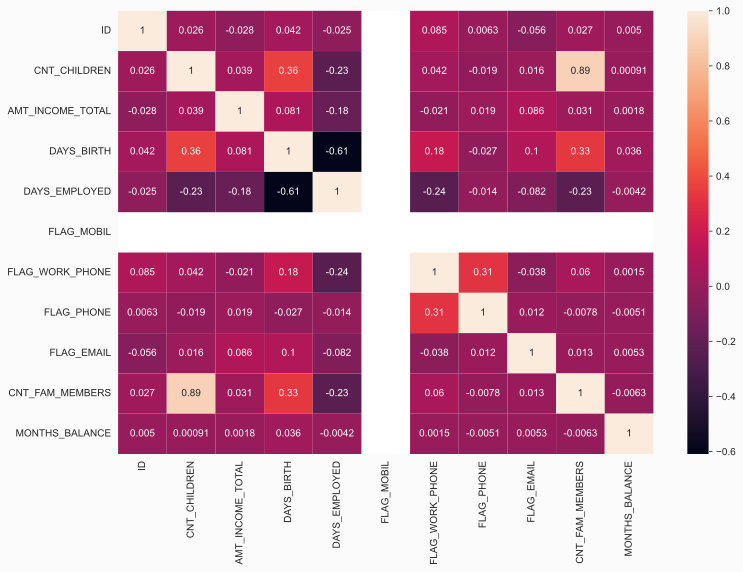

In [12]:
# correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(exclude='object').corr(), annot=True)

## Trying a simple merge

In [13]:
# credit_unique = credit.drop_duplicates(subset=['ID', 'MONTHS_BALANCE'], keep='first')
credit_unique = credit.drop_duplicates(subset=['ID'], keep='last')
credit_unique.head(5)

,ID,MONTHS_BALANCE,STATUS
3,5001711,-3,0
22,5001712,-18,0
44,5001713,-21,X
59,5001714,-14,X
119,5001715,-59,X


In [14]:
# merge the two tables
df = pd.merge(application, credit_unique, on='ID', how='inner')
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15,X
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14,X
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29,X
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4,X
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26,X


In [15]:
# Select the columns where you want to remove outliers
columns_to_filter = ['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS', 'CNT_CHILDREN']

# Calculate lower and upper bounds for each selected column
lower_bounds = df[columns_to_filter].quantile(0.05)
upper_bounds = df[columns_to_filter].quantile(0.90)

# Define the boundaries for outlier removal
lower_bound_limits = lower_bounds - 0.05 * (upper_bounds - lower_bounds)
upper_bound_limits = upper_bounds + 0.05 * (upper_bounds - lower_bounds)

# Filter out the rows containing outliers in any of the selected columns
df = df[~((df[columns_to_filter] < lower_bound_limits) | (df[columns_to_filter] > upper_bound_limits)).any(axis=1)]
Markdown('**Filtered data shape:** ' + str(df.shape))

**Filtered data shape:** (29837, 20)

<Axes: >

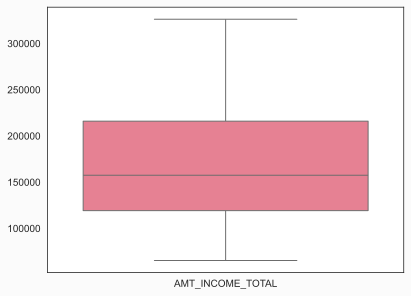

In [16]:
sns.boxplot(data=df[["AMT_INCOME_TOTAL"]])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29837 entries, 2 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   29837 non-null  int64  
 1   CODE_GENDER          29837 non-null  object 
 2   FLAG_OWN_CAR         29837 non-null  object 
 3   FLAG_OWN_REALTY      29837 non-null  object 
 4   CNT_CHILDREN         29837 non-null  int64  
 5   AMT_INCOME_TOTAL     29837 non-null  float64
 6   NAME_INCOME_TYPE     29837 non-null  object 
 7   NAME_EDUCATION_TYPE  29837 non-null  object 
 8   NAME_FAMILY_STATUS   29837 non-null  object 
 9   NAME_HOUSING_TYPE    29837 non-null  object 
 10  DAYS_BIRTH           29837 non-null  int64  
 11  DAYS_EMPLOYED        29837 non-null  int64  
 12  FLAG_MOBIL           29837 non-null  int64  
 13  FLAG_WORK_PHONE      29837 non-null  int64  
 14  FLAG_PHONE           29837 non-null  int64  
 15  FLAG_EMAIL           29837 non-null  int6

In [18]:
# categorical columns
pprint(list(df.select_dtypes('object').columns))

[
│   'CODE_GENDER',
│   'FLAG_OWN_CAR',
│   'FLAG_OWN_REALTY',
│   'NAME_INCOME_TYPE',
│   'NAME_EDUCATION_TYPE',
│   'NAME_FAMILY_STATUS',
│   'NAME_HOUSING_TYPE',
│   'OCCUPATION_TYPE',
│   'STATUS'
]

In [19]:
# Label Encoding
df_encoded = df.copy()
lst = list(df_encoded.select_dtypes('object').columns)
for i in lst :
  lb = LabelEncoder()
  df_encoded[i] = lb.fit_transform(df_encoded[i])
df_encoded

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
2,5008806,1,1,1,0,112500.0,4,4,1,1,-21474,-1134,1,0,0,0,16,2.0,-29,4
3,5008808,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,14,1.0,-4,4
4,5008809,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,14,1.0,-26,4
5,5008810,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,14,1.0,-26,4
6,5008811,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,14,1.0,-38,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,1,1,1,0,315000.0,4,4,1,1,-17348,-2420,1,0,0,0,10,2.0,-11,4
36453,5149834,0,0,1,0,157500.0,0,1,1,1,-12387,-1325,1,0,1,1,11,2.0,-23,0
36454,5149838,0,0,1,0,157500.0,1,1,1,1,-12387,-1325,1,0,1,1,11,2.0,-32,0
36455,5150049,0,0,1,0,283500.0,4,4,1,1,-17958,-655,1,0,0,0,14,2.0,-9,0


In [20]:
# sns.pairplot(data=df )

In [21]:
x = df_encoded.drop(["ID", "STATUS", "FLAG_PHONE"], axis=1)
y = df['STATUS']

In [22]:
smote = SMOTE()
X_balance, Y_balance = smote.fit_resample(x, y)

ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 1, n_samples = 1

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29837 entries, 2 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   29837 non-null  int64  
 1   CODE_GENDER          29837 non-null  object 
 2   FLAG_OWN_CAR         29837 non-null  object 
 3   FLAG_OWN_REALTY      29837 non-null  object 
 4   CNT_CHILDREN         29837 non-null  int64  
 5   AMT_INCOME_TOTAL     29837 non-null  float64
 6   NAME_INCOME_TYPE     29837 non-null  object 
 7   NAME_EDUCATION_TYPE  29837 non-null  object 
 8   NAME_FAMILY_STATUS   29837 non-null  object 
 9   NAME_HOUSING_TYPE    29837 non-null  object 
 10  DAYS_BIRTH           29837 non-null  int64  
 11  DAYS_EMPLOYED        29837 non-null  int64  
 12  FLAG_MOBIL           29837 non-null  int64  
 13  FLAG_WORK_PHONE      29837 non-null  int64  
 14  FLAG_PHONE           29837 non-null  int64  
 15  FLAG_EMAIL           29837 non-null  int6

In [215]:
numerical_vars = df.select_dtypes(exclude='object').columns.tolist()
numerical_vars

['ID',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'MONTHS_BALANCE']

---

In [256]:
df_001 = df.copy()

In [260]:
df['STATUS'].value_counts()

STATUS
0    21555
X    14591
C      302
1        8
5        1
Name: count, dtype: int64

In [257]:
df_001['TARGET'] = df_001['STATUS']
df_001['TARGET'].replace("C" , "GOOD" , inplace = True)
df_001['TARGET'].replace("X" , "GOOD" , inplace = True)
df_001['TARGET'].replace("0" , "GOOD" , inplace = True)
df_001['TARGET'].replace("1" , "GOOD" , inplace = True)
df_001['TARGET'].replace("2" , "BAD" , inplace = True)
df_001['TARGET'].replace("3" , "BAD" , inplace = True)
df_001['TARGET'].replace("4" , "BAD" , inplace = True)
df_001['TARGET'].replace("5" , "BAD" , inplace = True)

In [258]:
df_001['TARGET'].value_counts()

TARGET
GOOD    36456
BAD         1
Name: count, dtype: int64

In [218]:
# start label enncoder
column_data = ["TARGET","CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "TARGET"]
for col in column_data:
    label = LabelEncoder()
    df_001[col] = label.fit_transform(df_001[col].values)
df_001.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,TARGET
2,5008806,1,1,1,0,112500.0,4,4,1,1,-21474,-1134,1,0,0,0,Security staff,2.0,-29,X,1
3,5008808,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,Sales staff,1.0,-4,X,1
4,5008809,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,Sales staff,1.0,-26,X,1
5,5008810,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,Sales staff,1.0,-26,X,1
6,5008811,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,Sales staff,1.0,-38,X,1


In [221]:
df_001.shape

(29837, 21)

In [222]:
x = df_001.drop(['OCCUPATION_TYPE', 'STATUS', 'TARGET'], axis=True)
y = df_001['TARGET']

In [223]:
y.value_counts()

TARGET
1    29836
0        1
Name: count, dtype: int64

In [206]:
# data standarization 
sc = StandardScaler()
x_scaled = sc.fit_transform(x)

Text(0.5, 1.0, 'Explained Variance Ratio')

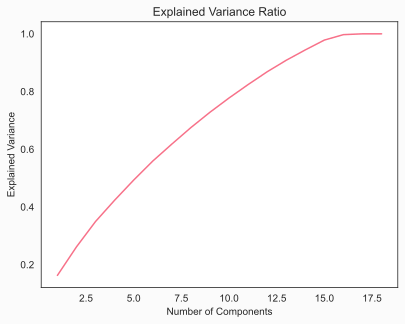

In [207]:
pca = PCA()
pct = pca.fit_transform(x_scaled)

# plt.figure(figsize=(6,4))
sns.lineplot(x=np.arange(1, len(pca.explained_variance_ratio_)+1), y=np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance Ratio')

In [208]:
print(len(x_scaled), len(y))

29837 29837


In [209]:
x_scaled

array([[-1.64644092e+00,  1.48777101e+00,  1.35806036e+00, ...,
        -3.09353768e-01,  3.86494567e-02, -1.78625121e-01],
       [-1.64639319e+00, -6.72146449e-01, -7.36344298e-01, ...,
         3.23254507e+00, -1.52817641e+00,  1.33386090e+00],
       [-1.64636933e+00, -6.72146449e-01, -7.36344298e-01, ...,
         3.23254507e+00, -1.52817641e+00,  2.87320131e-03],
       ...,
       [ 1.71917420e+00, -6.72146449e-01, -7.36344298e-01, ...,
         3.23254507e+00,  3.86494567e-02, -3.60123443e-01],
       [ 1.72420955e+00, -6.72146449e-01, -7.36344298e-01, ...,
        -3.09353768e-01,  3.86494567e-02,  1.03136369e+00],
       [ 1.73108244e+00,  1.48777101e+00, -7.36344298e-01, ...,
        -3.09353768e-01, -1.52817641e+00,  7.89365931e-01]])

In [194]:
undersample = RandomUnderSampler(random_state=13)
X, y = undersample.fit_resample(x_scaled, y)

In [195]:
x_scaled

array([[-1.64644092e+00,  1.48777101e+00,  1.35806036e+00, ...,
        -3.09353768e-01,  3.86494567e-02, -1.78625121e-01],
       [-1.64639319e+00, -6.72146449e-01, -7.36344298e-01, ...,
         3.23254507e+00, -1.52817641e+00,  1.33386090e+00],
       [-1.64636933e+00, -6.72146449e-01, -7.36344298e-01, ...,
         3.23254507e+00, -1.52817641e+00,  2.87320131e-03],
       ...,
       [ 1.71917420e+00, -6.72146449e-01, -7.36344298e-01, ...,
         3.23254507e+00,  3.86494567e-02, -3.60123443e-01],
       [ 1.72420955e+00, -6.72146449e-01, -7.36344298e-01, ...,
        -3.09353768e-01,  3.86494567e-02,  1.03136369e+00],
       [ 1.73108244e+00,  1.48777101e+00, -7.36344298e-01, ...,
        -3.09353768e-01, -1.52817641e+00,  7.89365931e-01]])

In [196]:
print(len(x_scaled), len(y))

29837 2


Class=1, n=29836 (99.997%)
Class=0, n=1 (0.003%)


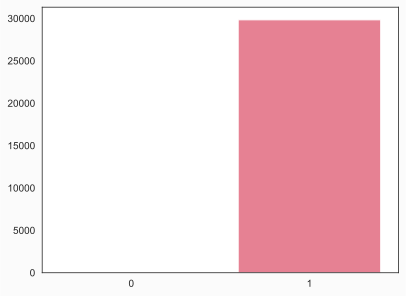

In [210]:
# summarize distribution
counter = Counter(y)

for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# plot the distribution
sns.barplot(counter)
plt.show()

In [198]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=11, shuffle=True)
y_test

0    0
Name: TARGET, dtype: int64

In [183]:
lr = LogisticRegression()
lr.fit(x_train,y_train)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

## Vintage Analysis

The vintage analysis measures the performance of a portfolio in different periods of time after the loan (or credit card) was granted.

In [40]:
# Creates a new DataFrame with the "OPEN_MONTH", "END_MONTH" and "WINDOW" columns
grouped = credit.groupby('ID')
pivot_tb = credit.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['OPEN_MONTH'] = grouped['MONTHS_BALANCE'].min() # smallest value of MONTHS_BALANCE, is the month when loan was granted
pivot_tb['END_MONTH'] = grouped['MONTHS_BALANCE'].max() # biggest value of MONTHS_BALANCE, end of observe window or end of loan
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'OPEN_MONTH', 'END_MONTH']]
pivot_tb['TIME_WINDOW'] = pivot_tb['END_MONTH'] - pivot_tb['OPEN_MONTH'] # calculate observe `window` of each ID
pivot_tb.reset_index(drop = True, inplace = True)  # reset index
pivot_tb

MONTHS_BALANCE,ID,OPEN_MONTH,END_MONTH,TIME_WINDOW
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59
...,...,...,...,...
45980,5150482,-28,-11,17
45981,5150483,-17,0,17
45982,5150484,-12,0,12
45983,5150485,-1,0,1


In [41]:
# Joining "OPEN_MONTH", "END_MONTH", "WINDOW" to the credit table
credit = pd.merge(credit_raw, pivot_tb, on = 'ID', how = 'left')
credit

,ID,MONTHS_BALANCE,STATUS,OPEN_MONTH,END_MONTH,TIME_WINDOW
0,5001711,0,X,-3,0,3
1,5001711,-1,0,-3,0,3
2,5001711,-2,0,-3,0,3
3,5001711,-3,0,-3,0,3
4,5001712,0,C,-18,0,18
...,...,...,...,...,...,...
1048570,5150487,-25,C,-29,0,29
1048571,5150487,-26,C,-29,0,29
1048572,5150487,-27,C,-29,0,29
1048573,5150487,-28,C,-29,0,29


#### How many IDS were left out from our Application's table?

In [26]:
len(application)
left_out_ids = application['ID'].nunique() - n_shared_ids
Markdown(f"From **{len(application)}** records, we are using only **{n_shared_ids}**, leaving out **{left_out_ids}** that are not in the credit table.")

From **438510** records, we are using only **36457**, leaving out **402053** that are not in the credit table.

In [27]:
# Create a new column to indicate whether the loan is default
credit['60_DAYS_DUE'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) # analyze > 60 days past due 
credit['60_DAYS_DUE'] = credit['60_DAYS_DUE'].astype(np.int8) # 1: overdue 0: not

In [28]:
count_60_days_due = credit['60_DAYS_DUE'].value_counts()
percentage = credit['60_DAYS_DUE'].value_counts(normalize=True) * 100
formatted = count_60_days_due.index.map(lambda x: f"{count_60_days_due[x]} ({percentage[x]:.1f}%)")
formatted
pd.DataFrame(formatted).T.style.set_caption("<h3> Default Status Count and Percentage")
# credit.to_csv('../data/processed/credit_record_with_windows.csv', index=False)

,0,1
60_DAYS_DUE,1045471 (99.7%),3104 (0.3%)


In [29]:
credit['MONTH_ON_BOOK'] = credit['MONTHS_BALANCE'] - credit['OPEN_MONTH'] # calculate month on book: how many months after opening account
credit.sort_values(by = ['ID','MONTH_ON_BOOK'], inplace = True)
credit.head(10)

,ID,MONTHS_BALANCE,STATUS,OPEN_MONTH,END_MONTH,TIME_WINDOW,60_DAYS_DUE,MONTH_ON_BOOK
3,5001711,-3,0,-3,0,3,0,0
2,5001711,-2,0,-3,0,3,0,1
1,5001711,-1,0,-3,0,3,0,2
0,5001711,0,X,-3,0,3,0,3
22,5001712,-18,0,-18,0,18,0,0
21,5001712,-17,0,-18,0,18,0,1
20,5001712,-16,0,-18,0,18,0,2
19,5001712,-15,0,-18,0,18,0,3
18,5001712,-14,0,-18,0,18,0,4
17,5001712,-13,0,-18,0,18,0,5


In [30]:
# denominator
denominator = pivot_tb.groupby(['OPEN_MONTH']).agg({'ID': ['count']}) # count how many users in every month the account was opened
denominator.reset_index(inplace = True)
denominator.columns = ['OPEN_MONTH','STA_SUM']
denominator.head(10)

,OPEN_MONTH,STA_SUM
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470
5,-55,486
6,-54,468
7,-53,493
8,-52,553
9,-51,582


In [31]:
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'axes.grid': False,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': '#fbfbfb',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': <CapStyle.round: 'round'>,
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': False,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

Text(0.5, 1.0, 'Cumulative Number of Accounts Opened Over Time')

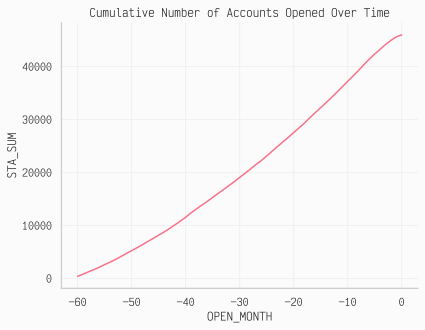

In [32]:
my_fonts = ["SN Pro", "Victor Mono", "Input Mono", "Input Mono Narrow", "Monaspace Neon Var", "PragmataPro Mono Liga", "Iosevka", "Monolisa", "JetBrains Mono Medium", "JetBrains Mono Light", "CommitMono", "Menlo", "Monaco"]

custom_params = { "font.family": my_fonts[1], "font.sans-serif": my_fonts[7], "grid.color": ".94", "figure.facecolor": "#FBFBFB", "axes.facecolor": "#FBFBFB", "axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(style="whitegrid", rc=custom_params)

# sns.set_style("whitegrid")

# sns.set_style("white")
sns.set_palette("husl") 

cum_sum = denominator['STA_SUM'].cumsum()
sns.lineplot(x = 'OPEN_MONTH', y = cum_sum, data = denominator)
plt.title('Cumulative Number of Accounts Opened Over Time')

In [33]:
import plotly.io as pio

pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [34]:
plotly_template = pio.templates["plotly_dark"]
plotly_template.layout

Layout({
    'annotationdefaults': {'arrowcolor': '#f2f5fa', 'arrowhead': 0, 'arrowwidth': 1},
    'autotypenumbers': 'strict',
    'coloraxis': {'colorbar': {'outlinewidth': 0, 'ticks': ''}},
    'colorscale': {'diverging': [[0, '#8e0152'], [0.1, '#c51b7d'], [0.2,
                                 '#de77ae'], [0.3, '#f1b6da'], [0.4, '#fde0ef'],
                                 [0.5, '#f7f7f7'], [0.6, '#e6f5d0'], [0.7,
                                 '#b8e186'], [0.8, '#7fbc41'], [0.9, '#4d9221'],
                                 [1, '#276419']],
                   'sequential': [[0.0, '#0d0887'], [0.1111111111111111,
                                  '#46039f'], [0.2222222222222222, '#7201a8'],
                                  [0.3333333333333333, '#9c179e'],
                                  [0.4444444444444444, '#bd3786'],
                                  [0.5555555555555556, '#d8576b'],
                                  [0.6666666666666666, '#ed7953'],
                           

In [35]:
import plotly.express as px

# for template in pio.templates:
for template in dash_templates:

    fig = px.line(denominator, x = "OPEN_MONTH",
                  y = "STA_SUM",
                  title = "<b>Number of Accounts Opened Over Time</b>",
                  template = template,
                  width = 700,
                  height = 500,
                  )
    fig.update_xaxes(title_text = "Open Month")
    fig.update_yaxes(title_text = "Number of Accounts")
    fig.update_layout(
        {
            "paper_bgcolor": "rgba(0, 0, 0, 0)",
            "plot_bgcolor": "rgba(0, 0, 0, 0)",
            "font": {
                "family": my_fonts[0],
                "color": "black",
                },
        }
    )
    fig.show()


NameError: name 'dash_templates' is not defined

In [36]:
# vintage table
vintage = credit.groupby(['OPEN_MONTH','MONTH_ON_BOOK']).agg({'ID': ['count']}) 
vintage.reset_index(inplace = True)
vintage.columns = ['OPEN_MONTH','MONTH_ON_BOOK','STA_SUM']
vintage['DUE_COUNT'] = np.nan
vintage = vintage[['OPEN_MONTH','MONTH_ON_BOOK','DUE_COUNT']] # delete STA_SUM column
vintage = pd.merge(vintage, denominator, on = ['OPEN_MONTH'], how = 'left') # join STA_SUM colun to vintage table
vintage

,OPEN_MONTH,MONTH_ON_BOOK,DUE_COUNT,STA_SUM
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415
...,...,...,...,...
1886,-2,1,NaN,771
1887,-2,2,NaN,771
1888,-1,0,NaN,686
1889,-1,1,NaN,686


In [37]:
temp_vintage = vintage.copy()

for j in range(-60,1): # outer loop: month in which account was opened
    ls = []
    for i in range(0,61): # inner loop time after the credit card was granted
        due = list(credit[(credit['60_DAYS_DUE'] == 1) & (credit['MONTH_ON_BOOK'] == i) & (credit['OPEN_MONTH'] == j)]['ID']) # get ID which satisfy the condition
        ls.extend(due) # As time goes, add bad customers
        temp_vintage.loc[(temp_vintage['MONTH_ON_BOOK'] == i) & (temp_vintage['OPEN_MONTH'] == j), 'DUE_COUNT'] = len(set(ls)) # calculate non-duplicate ID numbers using set()

temp_vintage.head(10)

,OPEN_MONTH,MONTH_ON_BOOK,DUE_COUNT,STA_SUM
0,-60,0,0.0,415
1,-60,1,0.0,415
2,-60,2,0.0,415
3,-60,3,0.0,415
4,-60,4,0.0,415
5,-60,5,1.0,415
6,-60,6,1.0,415
7,-60,7,3.0,415
8,-60,8,3.0,415
9,-60,9,4.0,415


In [38]:
vintage['DUE_COUNT'] = temp_vintage['DUE_COUNT']

In [39]:
vintage['STA_RATE']  = vintage['DUE_COUNT'] / vintage['STA_SUM'] # calculate cumulative % of bad customers
vintage['STA_RATE'] = vintage['STA_RATE'].fillna(0) # fill NA with 0
vintage.head(10)

,OPEN_MONTH,MONTH_ON_BOOK,DUE_COUNT,STA_SUM,STA_RATE
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
5,-60,5,1.0,415,0.002410
6,-60,6,1.0,415,0.002410
7,-60,7,3.0,415,0.007229
8,-60,8,3.0,415,0.007229
9,-60,9,4.0,415,0.009639


In [288]:
# Vintage wide table
vintage_wide = vintage.copy()
vintage_wide['CUM_SUM'] = vintage_wide['STA_SUM'].groupby(vintage_wide['OPEN_MONTH']).cumsum() # calculate cumulative number of accounts opened
vintage_wide['STA_RATE_PER'] = vintage_wide['STA_RATE'] * 100
vintage_wide = vintage_wide.pivot(index = 'OPEN_MONTH',
                             columns = 'MONTH_ON_BOOK',
                             values = 'STA_RATE_PER')
vintage_wide.style.format("{:.2f}").set_caption("Vintage analysis table: Cumulative % of Bad Customers by Vintage Cohort")
# vintage_wide.style.bar(axis=0, color='#d65f5f').format("{:.3f}")

MONTH_ON_BOOK,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
OPEN_MONTH,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-60,0.00,0.00,0.00,0.00,0.00,0.24,0.24,0.72,0.72,0.96,0.96,1.20,1.45,1.69,1.69,1.69,1.69,1.69,1.69,1.69,1.69,1.93,1.93,1.93,1.93,2.17,2.17,2.17,2.17,2.41,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.65,2.89,2.89,2.89,2.89,2.89,2.89,2.89,2.89,3.13,3.13,3.13
-59,0.00,0.00,0.00,0.49,0.49,0.49,0.74,0.74,0.74,1.23,1.23,1.97,1.97,1.97,1.97,1.97,1.97,1.97,2.22,2.46,2.46,2.71,2.71,2.71,2.71,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,2.96,3.20,3.20,3.20,3.20,3.20,3.20,nan
-58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.45,0.68,0.68,1.14,1.36,1.36,1.36,1.36,1.36,1.36,1.59,1.82,1.82,1.82,2.27,2.27,2.27,2.27,2.27,2.27,2.27,2.27,2.27,2.27,2.27,2.27,2.27,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,nan,nan
-57,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.75,0.75,0.75,0.75,0.75,1.00,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,1.75,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.25,2.25,2.25,2.25,2.25,2.25,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,2.50,nan,nan,nan
-56,0.00,0.00,0.43,0.43,0.85,1.06,1.06,1.70,1.70,2.13,2.13,2.55,2.98,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.62,3.62,3.62,3.62,3.83,3.83,nan,nan,nan,nan
-55,0.00,0.00,0.41,0.82,1.44,1.85,2.47,2.47,2.47,2.67,2.67,2.67,2.88,3.50,3.70,3.91,4.12,4.12,4.12,4.12,4.12,4.12,4.12,4.12,4.12,4.12,4.32,4.32,4.32,4.32,4.32,4.32,4.32,4.53,4.53,4.53,4.53,4.53,4.53,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,4.73,nan,nan,nan,nan,nan
-54,0.00,0.00,0.00,0.21,0.43,0.43,0.64,1.28,1.28,1.71,1.92,1.92,2.35,2.78,2.78,2.99,2.99,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,3.21,nan,nan,nan,nan,nan,nan
-53,0.00,0.41,0.61,0.61,0.81,0.81,1.22,1.42,1.42,1.62,1.83,1.83,1.83,1.83,1.83,1.83,1.83,1.83,2.03,2.03,2.03,2.03,2.03,2.03,2.03,2.03,2.43,2.43,2.43,2.43,2.43,2.43,2.43,2.43,2.84,2.84,2.84,2.84,2.84,2.84,2.84,2.84,2.84,2.84,2.84,2.84,2.84,3.04,3.25,3.25,3.25,3.25,3.25,3.25,nan,nan,nan,nan,nan,nan,nan
-52,0.00,0.00,0.72,0.90,0.90,0.90,1.27,1.27,1.45,1.63,1.63,1.63,1.81,1.81,1.81,1.99,1.99,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.17,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,2.35,nan,nan,nan,nan,nan,nan,nan,nan


The rows represent months of opening accounts, columns represent months after openning acounts, and values are accumlate past-due rate. As open-month closes to 0, the observe window shortens, thus the bottom half triangular field is filled by nan.

### Cumulative % of Bad Customers (> 60 Days Past Due)

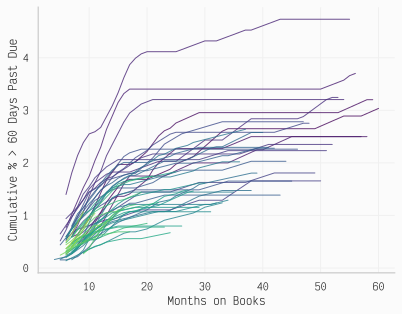

In [289]:
# plot vintage line chart
vintage_tmp = vintage_wide.copy()
vintage_tmp = vintage_tmp.replace(0, np.nan)
sns.lineplot(data=vintage_tmp.T.rolling(window=5).mean(), legend=False, palette='viridis', linewidth=1, dashes=False, alpha=0.8)
plt.xlabel('Months on Books')
plt.ylabel('Cumulative % > 60 Days Past Due')
plt.grid(True)
plt.show()

In [290]:
# !pip install dash-bootstrap-templates
import dash_bootstrap_components
from dash_bootstrap_templates import load_figure_template


dash_templates = [
"bootstrap",
"cerulean",
"cosmo",
"flatly",
"journal",
"litera",
"lumen",
"lux",
"materia",
"minty",
"pulse",
"sandstone",
"simplex",
"sketchy",
"spacelab",
"united",
"yeti",
"cyborg",
"darkly",
"slate",
"solar",
"superhero",
"morph",
"quartz",
"vapor"
"zephyr"
]

dir(dash_bootstrap_components)
load_figure_template(dash_templates)

In [ ]:
# for template in list(pio.templates): #[4:5]:
for template in dash_templates:
    # sns.lineplot(data=vintage_tmp.T.rolling(window=5).mean(), legend=False, palette='viridis', linewidth=1, dashes=False, alpha=0.8)
    fig = px.line(
        vintage_tmp.T,
        # title = "<b>Cumulative % of Bad Customers by Vintage Cohort",
        template = template,
        # width=800,
        # height=600,
        )
    # fig.update_xaxes(title_text = "Months on Books")
    # fig.update_yaxes(title_text = "Cumulative % > 60 Days Past Due")
    # fig.update_layout(
    #     {
    #         "paper_bgcolor": "rgba(0, 0, 0, 0)",
    #         "plot_bgcolor": "rgba(0, 0, 0, 0)",
    #         "showlegend": False,
    #         "font": {
    #             "family": my_fonts[0],
    #             "color": "black",
    #             },
    #     }
    # )
    fig.show()


# Observe Window Analysis

Our accounts data is cut short due to account cancellations and the end of observation periods. The observation window is an important factor to consider. If the window is too short, we might miss out on important user behaviors, leading to noise in our data.

To see how the number of accounts changes as we extend the observation window, we created a plot.

In [291]:
pivot_tb.head(5)

MONTHS_BALANCE,ID,OPEN_MONTH,END_MONTH,TIME_WINDOW
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59


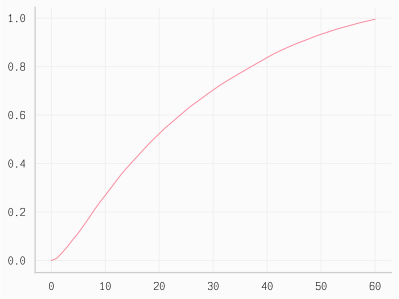

In [292]:
lst = []
for i in range(0,61):
    ratio = len(pivot_tb[pivot_tb['TIME_WINDOW'] < i]) / len(set(pivot_tb['ID']))
    lst.append(ratio)

ax = sns.lineplot(pd.Series(lst), palette='viridis', linewidth=1, dashes=False, alpha=0.8)

We could see that a 60 months observe window covers all appliers, while 20 months window contains about 52% records.

In [293]:
def calculate_observe(credit, command):
    id_sum = len(set(pivot_tb['ID']))
    credit['status'] = 0
    exec(command)
    credit['MONTH_ON_BOOK'] = credit['MONTHS_BALANCE'] - credit['OPEN_MONTH']
    minagg = credit[credit['60_DAYS_DUE'] == 1].groupby('ID')['MONTH_ON_BOOK'].min()
    minagg = pd.DataFrame(minagg)
    minagg['ID'] = minagg.index
    obslst = pd.DataFrame({'MONTH_ON_BOOK':range(0,61), 'rate': None})
    lst = []

    for i in range(0,61):
        due = list(minagg[minagg['MONTH_ON_BOOK']  == i]['ID'])
        lst.extend(due)
        obslst.loc[obslst['MONTH_ON_BOOK'] == i, 'rate'] = len(set(lst)) / id_sum 
    return obslst['rate']

command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), '60_DAYS_DUE'] = 1"   
morethan1 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), '60_DAYS_DUE'] = 1"
morethan60 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), '60_DAYS_DUE'] = 1"
morethan90 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), '60_DAYS_DUE'] = 1"
morethan120 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '5'), '60_DAYS_DUE'] = 1"
morethan150 = calculate_observe(credit, command)

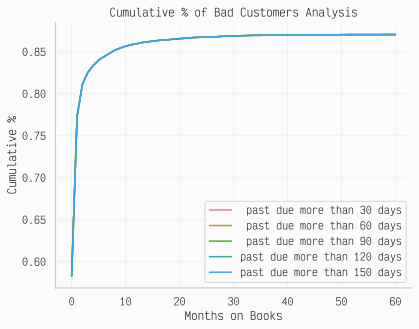

In [294]:
obslst = pd.DataFrame({' past due more than 30 days': morethan30,
                       ' past due more than 60 days': morethan60,
                       ' past due more than 90 days': morethan90,
                       'past due more than 120 days': morethan120,
                       'past due more than 150 days': morethan150
                        })

obslst.plot(grid = True, title = 'Cumulative % of Bad Customers Analysis')
plt.xlabel('Months on Books')
plt.ylabel('Cumulative %')
plt.show()

This plot could be seen as a average (across open-month) version of vintage plot.
For longer past due date, it needs longer observe window. For example, more than 150 days past due needs at least 5 months until first *bad customer* appears. For most situation, a 20-months observe window could cover most *bad customer*. However, For 30 days past due, we could see that after 30 months on books, there still are new *bad customer* join in the list. So a 20 MOB observe window will be appropriate. Those who exists shorter than the observe window should be excluded from our analysis, thus you could see I deleted users whose observe window less than 20 on last section (the window could be changed).

# Overall Past-due Ratio

Calculating overall past-due rate. Respectively, we analyze 1 day past due, 20 days past due, 60 days past due, 90 days past due, 120 days past due, 150 days past due. This analysis could help us to define who are *bad customers*. We could see that almost 87% users have past due more than 1 day, which is too common, thus it's inappropriate to be a standard. What about 150 days overdue? Only 0.4% of accounts appear to past due that long. If we use that, we will left many *bad customers* in our scrutiny. A table like that will help you to determine what  will be the most suitable standard of *bad customers*.

In [295]:
def calculate_rate(pivot_tb, command): 
    '''calculate bad customer rate
    '''
    credit['60_DAYS_DUE'] = None
    exec(command) # excuate input code
    sumagg = credit.groupby('ID')['60_DAYS_DUE'].agg(sum)
    pivot_tb = pd.merge(pivot_tb, sumagg, on = 'ID', how = 'left')
    pivot_tb.loc[pivot_tb['60_DAYS_DUE'] > 1, '60_DAYS_DUE'] = 1
    rate = pivot_tb['60_DAYS_DUE'].sum() / len(pivot_tb)
    return round(rate, 5)

command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), '60_DAYS_DUE'] = 1"   
morethan1 = calculate_rate(pivot_tb, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), '60_DAYS_DUE'] = 1"   
morethan30 = calculate_rate(pivot_tb, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), '60_DAYS_DUE'] = 1"
morethan60 = calculate_rate(pivot_tb, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), '60_DAYS_DUE'] = 1"
morethan90 = calculate_rate(pivot_tb, command)
command = "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), '60_DAYS_DUE'] = 1"
morethan120 = calculate_rate(pivot_tb, command)
command = "credit.loc[(credit['STATUS'] == '5'), '60_DAYS_DUE'] = 1"
morethan150 = calculate_rate(pivot_tb, command)

summary_dt = pd.DataFrame({'situation':['past due more than 1 day',
                               'past due more than 30 days',
                               'past due more than 60 days',
                               'past due more than 90 days',
                               'past due more than 120 days',
                               'past due more than 150 days'],
                      'bad customer ratio':[morethan1,
                               morethan30,
                               morethan60,
                               morethan90, 
                               morethan120,
                               morethan150, 
                      ]})
summary_dt

,situation,bad customer ratio
0,past due more than 1 day,0.87054
1,past due more than 30 days,0.11634
2,past due more than 60 days,0.01450
3,past due more than 90 days,0.00720
4,past due more than 120 days,0.00528
5,past due more than 150 days,0.00424


## EDA Summary

Given the vintage analysis, we decided that will need to observe a customer for about **20 months** before deciding if he is a good or bad one.